### Cena 1
- Simulação com a mini câmara sem material.
- Aplicando impedância de superfície calculada apartir da formulação da ISO 354.


### Importando bibliotecas


In [1]:
# Importando bibliotecas

import femder as fd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle
from femder.FEM_3D import  p2SPL

Default Plotly renderer: jupyterlab


### Importando resultados experimentais
- velocidade de volume
- coef. absorção ISO 354
- sinal medido nos receptores
- respostas impulsivas

In [24]:
import scipy.io as sio

q = sio.loadmat(r'C:\\Users\\kemer\\Documents\\CaixasAcusticas\\diafragma_altofalante_Eric_Paulo_Eletroacustica\\Qi.mat')
# sorted(q.keys())
q = q['Qi']

as_medido = sio.loadmat(r'G:\\Meu Drive\\TCC\\Experimental\\sem_material\\as_vazia.mat')
# sorted(as_medido.keys())

R_semMat = sio.loadmat(r'G:\\Meu Drive\\TCC\\Experimental\\Medicao_tcc2\\Dados_medicao\\R_semMatfreq.mat')
# sorted(R_semMat.keys())

RI_semMat = sio.loadmat(r'G:\\Meu Drive\\TCC\\Experimental\\sem_material\\RIs.mat')



### Importar geometria, inicializando as classes dos dados de entrada da simulação

In [25]:
# Importar geometria, inicializando as classes dos dados de entrada da simulação

path_to_geo = "G:\Meu Drive\TCC\Simulacao_computacional\codes\geo\mini-camarareverb.iges"

AP = fd.AirProperties(c0 = 343)
fmax = 2000 #2300
fmin = 150
AC = fd.AlgControls(AP,fmin,fmax,0.5)
S = fd.Source("spherical")
S.coord = np.array([[1.222,0.15,0.2]])
S.q = np.array(q)
#S.q = np.array([0.001])
R = fd.Receiver()
#R.coord = np.array([[0.33,0.23,0.21],[0.38,0.93,0.21],[0.92,0.95,0.21]]) 
R.coord = np.array([[1.057,0.695,0.282],[0.425,0.925,0.235],
                    [0.409,0.406,0.235],[0.336,0.677,0.282],
                    [0.685,0.965,0.235],[0.661,0.30,0.235]])
 

In [18]:
# Recuperando a impedância de superficie das paredes da minicamara apartir do coef. de abs medido pela ISO 354

from sea.sea.materials import Material as mat

#with open(r"G:\Meu Drive\TCC\codes\dados-pickle\admitance_minicamara1.pkl","rb") as arquivo:
  #sup_admittance = pickle.load(arquivo)
  
sup = mat(octave_bands_statistical_alpha = [0.0323, 0.0279, 0.0266, 0.0365, 0.0366], octave_bands = [250, 500, 1000, 2000, 4000], freq_vec=AC.freq)
sup.impedance_from_alpha(absorber_type="hard")
sup_admittance = sup.admittance # Admitancia normalizada
sup_surface_impedance = sup.surface_impedance # Impedancia não normalizada 

Working on the solution of the constrained optimization problem...
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0015943271909706238
            Iterations: 65
            Function evaluations: 405
            Gradient evaluations: 65
[9.84605011e-17 0.00000000e+00 6.32319722e+01 2.74731086e-01
 4.97876922e-01]
The solution of the optimization problem leads to rmk+1 parameters equal to [9.84605011e-17 0.00000000e+00 6.32319722e+01 2.74731086e-01
 4.97876907e-01].
Impedances, admittances and everything else related to it was already calculated.



In [20]:
with open('G:\Meu Drive\TCC\Simulacao_computacional\codes\dados-pickle\cena1\sup_admittance.pkl', "wb") as arquivo:
    pickle.dump(sup, arquivo)

# import pickle
# with open("G:\Meu Drive\TCC\Simulacao_computacional\codes\dados-pickle\cena1\sup_admittance.pkl","rb") as arquivo:
#   sup = pickle.load(arquivo)

In [21]:
# Boundary Conditions
BC = fd.BC(AC,AP) #[2,3,4,5,6,7]
BC.normalized_admittance(list(np.arange(2,8,1)),sup.admittance)

### Verificação da equivalência entre os alphas (in x recuperado)

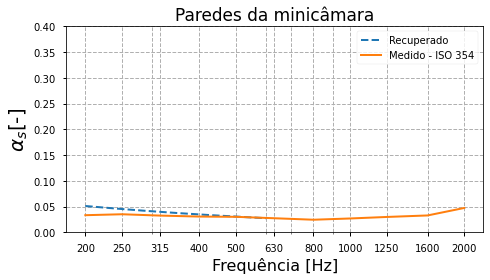

In [44]:
# Verificação da equivalência entre os coefs 
## () analisar recuperando com alphas em bando de terç de oitava
## () calcular erro entre os coefs

plt.figure(figsize=(7,4))
plt.semilogx(AC.freq, sup.statistical_alpha,label='Recuperado', linestyle='--', linewidth=2)
plt.semilogx(as_medido['f'][:11], as_medido['a_s'][:11], linestyle='-', label = 'Medido - ISO 354',linewidth=2)
plt.grid(linestyle = '--', which='both')
plt.legend(loc='best')
plt.title('Paredes da minicâmara', fontsize=17)
plt.xlabel('Frequência [Hz]', fontsize=16)
plt.ylabel(r'$\alpha_{s}$[-]', fontsize=20)
#plt.xticks([20,40,60,80,100,120,160,200],[20,40,60,80,100,120,160,200]);
plt.xticks([200,250,315,400,500,630,800,1000,1250,1600,2000],[200,250,315,400,500,630,800,1000,1250,1600,2000])
plt.tight_layout()
plt.ylim((0,0.4))
# plt.xlim((200,2000))
#plt.savefig("/content/drive/MyDrive/TCC/Documento/abs_teto.pdf")
plt.show()

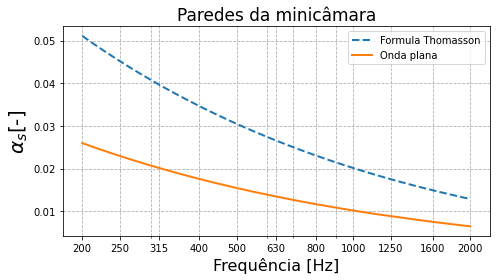

In [28]:
# Coeficiente de reflexão e absorção formula incidencia normal
z_ar = AP.c0*AP.rho0
Zs = sup_surface_impedance/z_ar
Reflexao = (Zs - 1) / (Zs + 1)
Absorcao = 1 - (np.abs(Reflexao) ** 2)  # 1 - |R|²
plt.figure(figsize=(7,4))
plt.semilogx(AC.freq, sup.statistical_alpha,label='Formula Thomasson', linestyle='--', linewidth=2)
plt.semilogx(AC.freq, Absorcao, linestyle='-', label = 'Incidência normal',linewidth=2)
plt.grid(linestyle = '--', which='both')
plt.legend(loc='best')
plt.title('Paredes da minicâmara', fontsize=17)
plt.xlabel('Frequência [Hz]', fontsize=16)
plt.ylabel(r'$\alpha_{s}$[-]', fontsize=20)
#plt.xticks([20,40,60,80,100,120,160,200],[20,40,60,80,100,120,160,200]);
plt.xticks([200,250,315,400,500,630,800,1000,1250,1600,2000],[200,250,315,400,500,630,800,1000,1250,1600,2000])
plt.tight_layout()
# plt.ylim((0,0.2))
# plt.xlim((200,2000))
#plt.savefig("/content/drive/MyDrive/TCC/Documento/abs_teto.pdf")
plt.show()

### Geração da malha, inicializando a classe FEM3D com os dados de entrada e o plote da geomeria com a malha 2D


In [26]:
grid = fd.GridImport3D(AP,path_to_geo,S,R,fmax = fmax,num_freq=6,scale=1000,order=1,load_method='meshio')
obj = fd.FEM3D(grid,S,R,AP,AC,BC)
obj.plot_problem(renderer='browser',saveFig=False,camera_angles=['diagonal_front'],extension='png')

### Cálculo das pressões com o método de elementos finitos

In [27]:
obj.compute() # debug e comparar vel const e dpendente freqa
obj.evaluate(R,True)

FEM | Assembling surface matrix: 100%|█████████████████████████| 6/6 [00:00<00:00, 44.34it/s]
100%|██████████| 3701/3701 [2:59:06<00:00,  2.90s/it]  


Time taken: 179.33888014554978 min


array([[-0.29423093+0.20400303j, -0.12402695-1.32909072j,
        -0.3656089 -2.11116026j, -0.18830728-1.74462793j,
        -0.12539974-0.62302632j, -0.41916862-1.32227136j],
       [-0.31050803+0.1107557j , -0.15499036-1.32180172j,
        -0.4347661 -2.14660314j, -0.23488867-1.74166459j,
        -0.14367122-0.63991928j, -0.47617389-1.40048616j],
       [-0.33430832+0.0159633j , -0.18756325-1.32030538j,
        -0.51092709-2.19477223j, -0.28435433-1.74757022j,
        -0.16447984-0.65989434j, -0.54219357-1.48835511j],
       ...,
       [-0.73774754-0.63570456j,  0.18108255+0.17628314j,
         0.80865482+0.10221613j,  0.78648024-0.34912264j,
         0.40519978-0.15827449j,  0.75292792+0.47930721j],
       [-0.79043617-1.10892582j, -0.19181391+0.07721855j,
         0.75913081-0.22218288j,  0.61083254-0.73344699j,
         0.02585191-0.38858911j,  0.56256244+0.24063541j],
       [-1.14853632-1.33605036j, -0.07207288+0.58580839j,
         0.21974772-0.67703312j,  0.05763899-0.79547837

In [36]:
# Salva var
with open("G:\Meu Drive\TCC\Simulacao_computacional\codes\dados-pickle\obj_Minicamara1_150_2000_0_5.pkl", "wb") as arquivo:
    pickle.dump(obj.pR, arquivo)


### Plote dos NPS resultantes em cada receptor

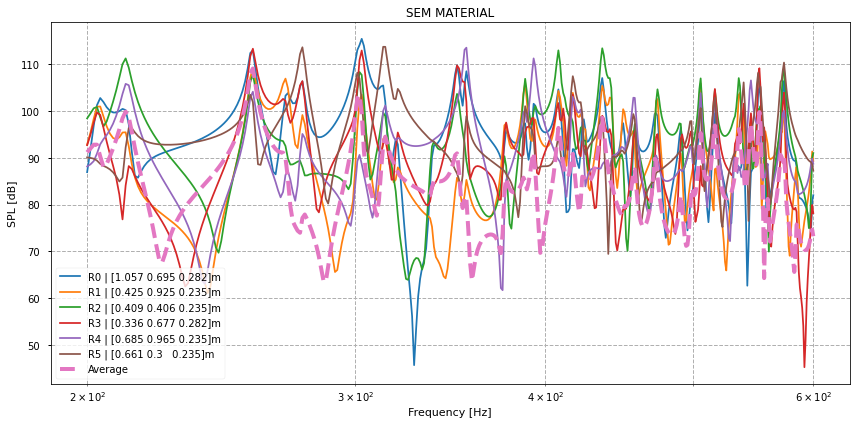

In [31]:

plt.style.use('seaborn-notebook')
plt.figure(figsize=(12,6))

if len(obj.R.coord)==1:
  plt.semilogx(obj.freq, p2SPL(obj.pR), linestyle='-', label=f'R | {obj.R.coord[0]}m')
else:
  for i in range(len(obj.R.coord)):
      plt.semilogx(obj.freq, p2SPL(obj.pR[:,i]), linestyle='-', label=f'R{i} | {obj.R.coord[i,:]}m')

if len(obj.R.coord) > 1:
  pR_med = np.mean(obj.pR,axis=1)
  plt.semilogx(obj.freq, p2SPL(pR_med), linestyle='--', label='Average', linewidth=4)
plt.title('SEM MATERIAL')
plt.grid(linestyle = '--', which='both')
plt.legend(loc='best')
plt.xlabel('Frequency [Hz]')
plt.ylabel('SPL [dB]')
#plt.ylim(40,160)
#plt.xticks([20,40,60,80,100,120,160,200],[20,40,60,80,100,120,160,200]);
#plt.xticks([100,125,160,200,250,315,400,500,630,1000,1250],[100,125,160,200,250,315,400,500,630,1000,1250]);
#plt.ylim(40,160)
plt.tight_layout()
plt.show()

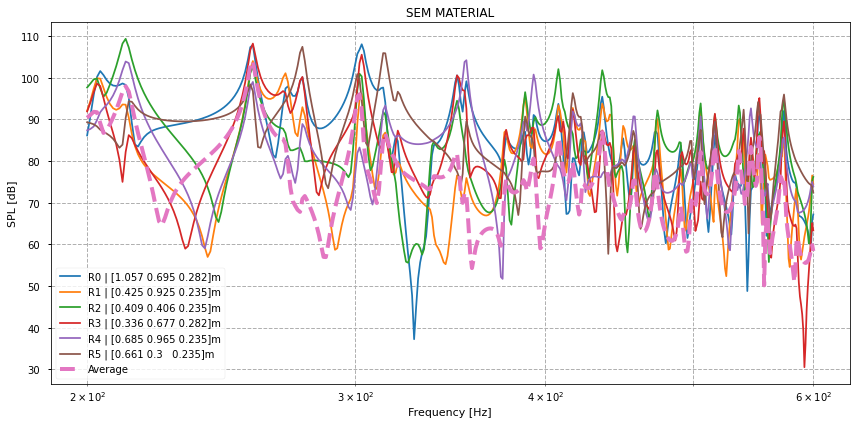

In [25]:
# Plote dos NPS resultantes em cada receptor
plt.style.use('seaborn-notebook')
plt.figure(figsize=(12,6))

if len(obj.R.coord)==1:
  plt.semilogx(obj.freq, p2SPL(obj.pR), linestyle='-', label=f'R | {obj.R.coord[0]}m')
else:
  for i in range(len(obj.R.coord)):
      plt.semilogx(obj.freq, p2SPL(obj.pR[:,i]), linestyle='-', label=f'R{i} | {obj.R.coord[i,:]}m')

if len(obj.R.coord) > 1:
  pR_med = np.mean(obj.pR,axis=1)
  plt.semilogx(obj.freq, p2SPL(pR_med), linestyle='--', label='Average', linewidth=4)
plt.title('SEM MATERIAL')
plt.grid(linestyle = '--', which='both')
plt.legend(loc='best')
plt.xlabel('Frequency [Hz]')
plt.ylabel('SPL [dB]')
#plt.ylim(40,160)
#plt.xticks([20,40,60,80,100,120,160,200],[20,40,60,80,100,120,160,200]);
#plt.xticks([100,125,160,200,250,315,400,500,630,1000,1250],[100,125,160,200,250,315,400,500,630,1000,1250]);
#plt.ylim(40,160)
plt.tight_layout()
plt.show()

### Comparação NPS dos pontos medido e simulado

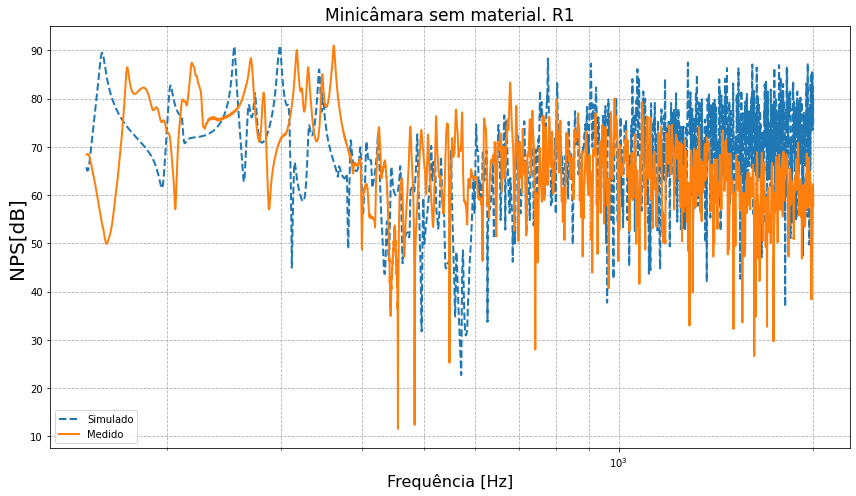

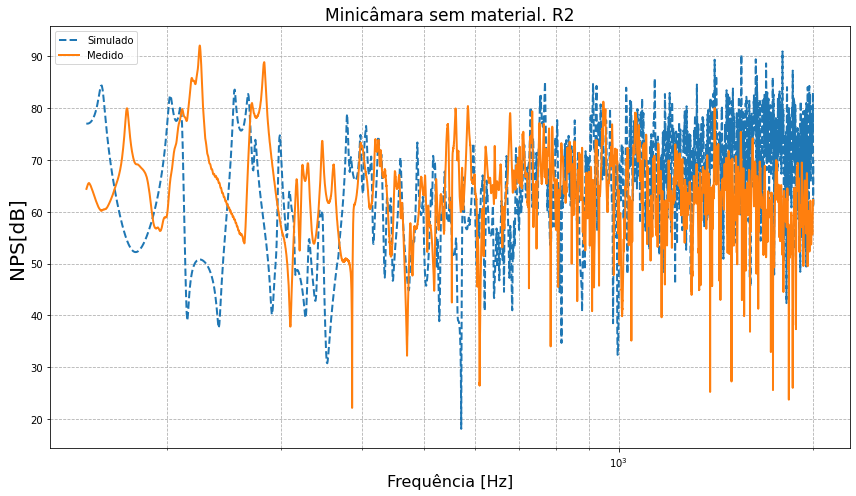

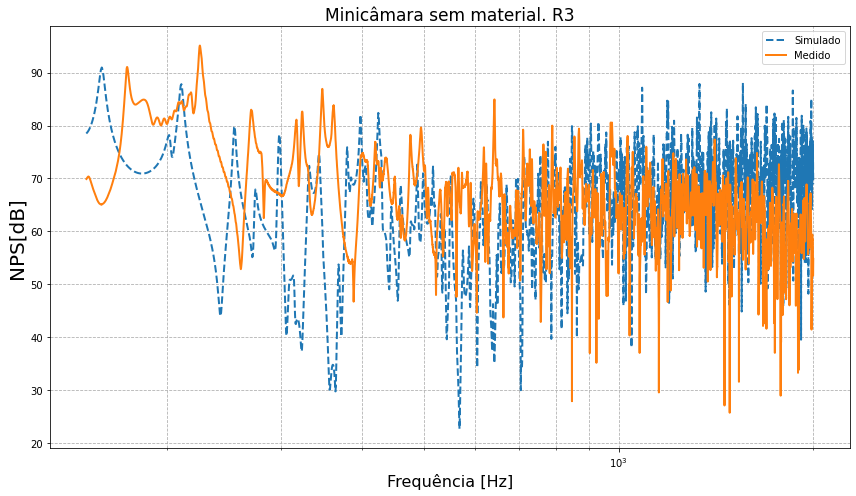

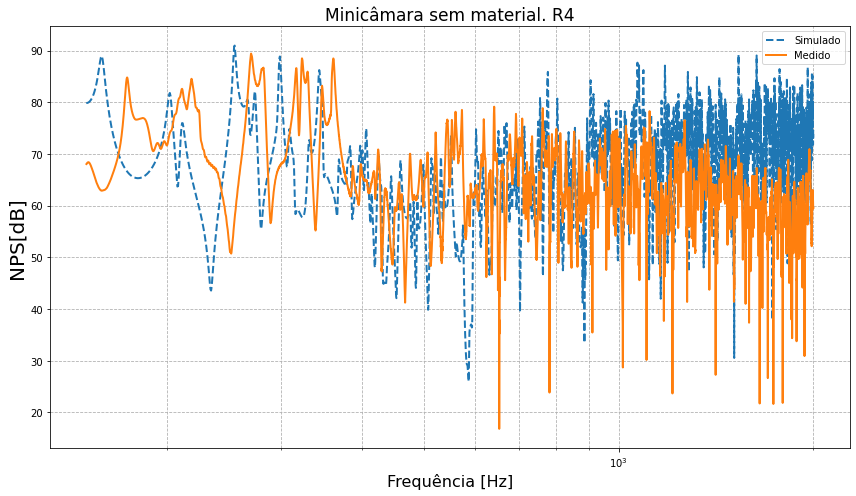

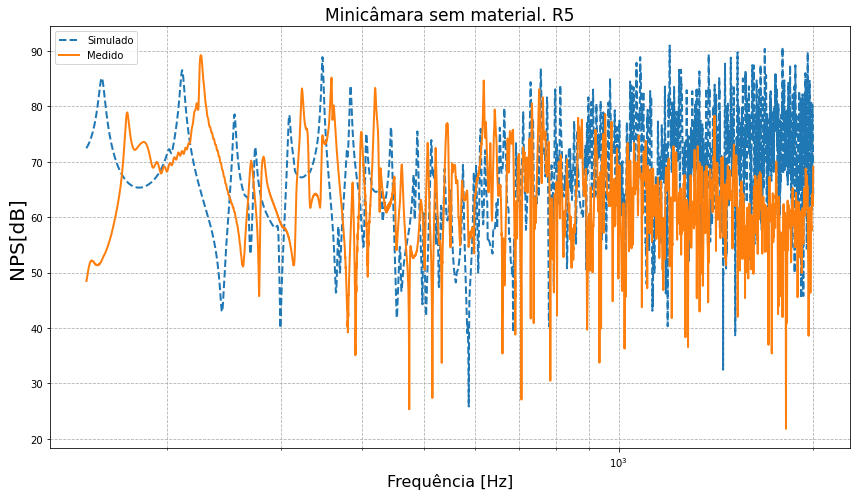

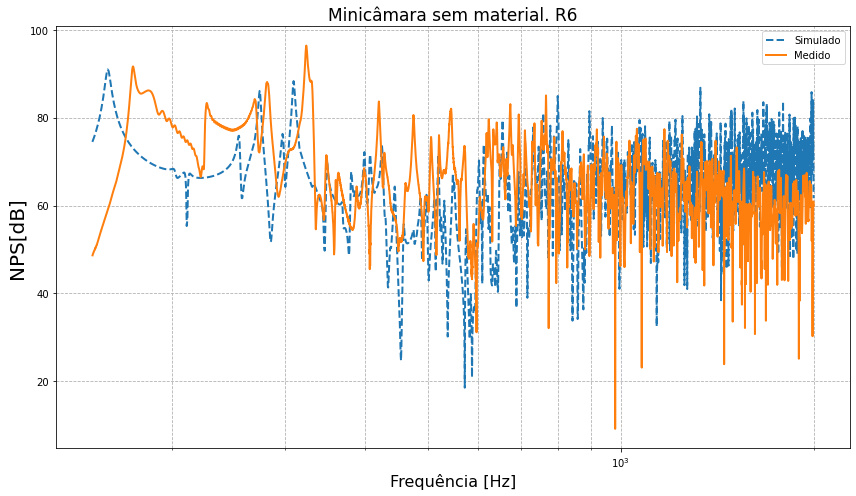

In [33]:
#Comparação NPS dos pontos medido e simulado  
# Q - Dependente da freq

for n in range(0,6):
    plt.figure(figsize=(12,7))
    plt.semilogx(AC.freq, p2SPL(obj.pR[:,n]/max(abs(obj.pR[:,n]))),label='Simulado', linestyle='--', linewidth=2)
    plt.semilogx(R_semMat['freqVector'][1981:26401,0], p2SPL(R_semMat['R_semMatfreq'][1981:26401,n]/max(abs(R_semMat['R_semMatfreq'][2641:7921,0]))), linestyle='-', label = 'Medido',linewidth=2)
    plt.grid(linestyle = '--', which='both')
    plt.legend(loc='best')
    plt.title(f'Minicâmara sem material. R{n+1}', fontsize=17)
    plt.xlabel('Frequência [Hz]', fontsize=16)
    plt.ylabel(r'NPS[dB]', fontsize=20)
#plt.xticks([20,40,60,80,100,120,160,200],[20,40,60,80,100,120,160,200]);
#plt.xticks([200,250,315,400,500,630,800,1000,1250,1600,2000],[200,250,315,400,500,630,800,1000,1250,1600,2000])
    plt.tight_layout()
# plt.ylim((0,0.2))
# plt.xlim((200,2000))
#plt.savefig("/content/drive/MyDrive/TCC/Documento/abs_teto.pdf")
    plt.show()  

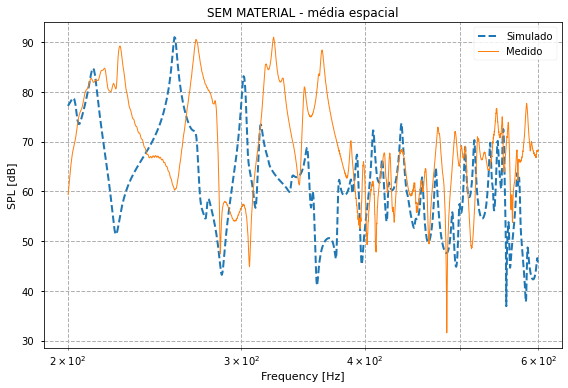

In [62]:
plt.title('SEM MATERIAL - média espacial')
pR_med = np.mean(obj.pR,axis=1) # R_semMat['R_semMatfreq'][2641:7921,n]
R_med = np.mean(R_semMat['R_semMatfreq'][2641:7921],axis=1)
plt.semilogx(obj.freq, p2SPL(pR_med/max(abs(pR_med))), linestyle='--', label='Simulado', linewidth=2)
plt.semilogx(R_semMat['freqVector'][2641:7921,0], p2SPL(R_med/max(abs(R_med))), linestyle='-', label='Medido', linewidth=1)
plt.grid(linestyle = '--', which='both')
plt.legend(loc='best')
plt.xlabel('Frequency [Hz]')
plt.ylabel('SPL [dB]')
# plt.ylim(40,160)
#plt.xticks([20,40,60,80,100,120,160,200],[20,40,60,80,100,120,160,200]);
#plt.xticks([100,125,160,200,250,315,400,500,630,1000,1250],[100,125,160,200,250,315,400,500,630,1000,1250]);
#plt.ylim(40,160)
plt.tight_layout()
plt.show()

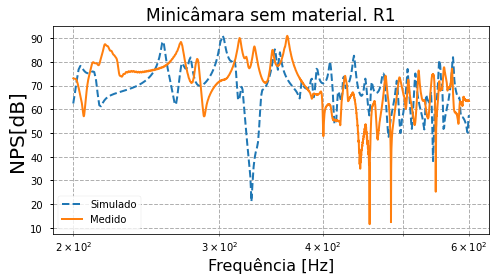

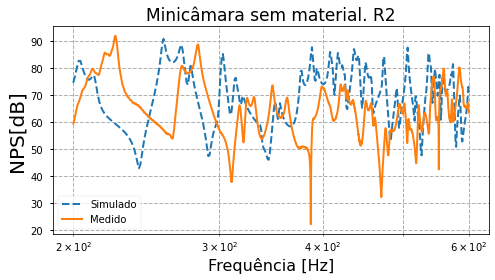

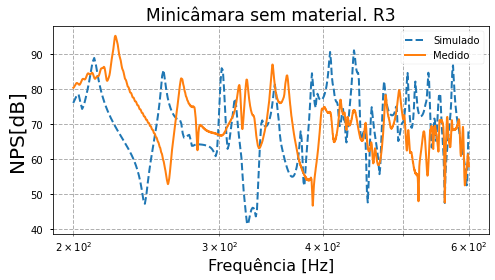

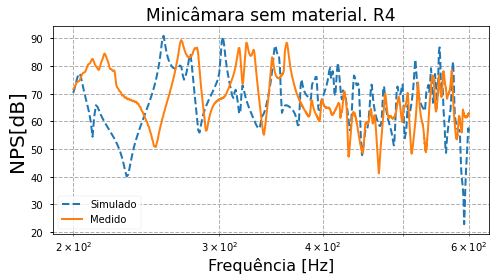

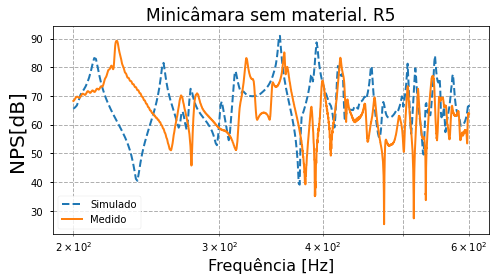

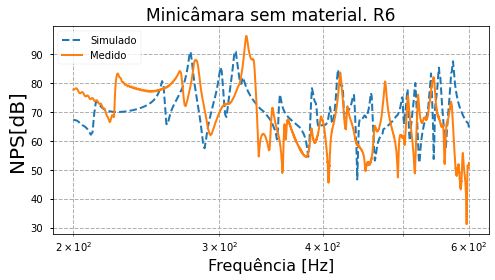

In [76]:
#Comparação NPS dos pontos medido e simulado 
# Q - cte.
for n in range(0,6):
    plt.figure(figsize=(7,4))
    plt.semilogx(AC.freq, p2SPL(obj.pR[:,n]/max(abs(obj.pR[:,n]))),label='Simulado', linestyle='--', linewidth=2)
    plt.semilogx(R_semMat['freqVector'][2641:7921,0], p2SPL(R_semMat['R_semMatfreq'][2641:7921,n]/max(abs(R_semMat['R_semMatfreq'][2641:7921,0]))), linestyle='-', label = 'Medido',linewidth=2)
    plt.grid(linestyle = '--', which='both')
    plt.legend(loc='best')
    plt.title(f'Minicâmara sem material. R{n+1}', fontsize=17)
    plt.xlabel('Frequência [Hz]', fontsize=16)
    plt.ylabel(r'NPS[dB]', fontsize=20)
#plt.xticks([20,40,60,80,100,120,160,200],[20,40,60,80,100,120,160,200]);
#plt.xticks([200,250,315,400,500,630,800,1000,1250,1600,2000],[200,250,315,400,500,630,800,1000,1250,1600,2000])
    plt.tight_layout()
# plt.ylim((0,0.2))
# plt.xlim((200,2000))
#plt.savefig("/content/drive/MyDrive/TCC/Documento/abs_teto.pdf")
    plt.show()  

### Comparação RIs dos pontos medido e simulado

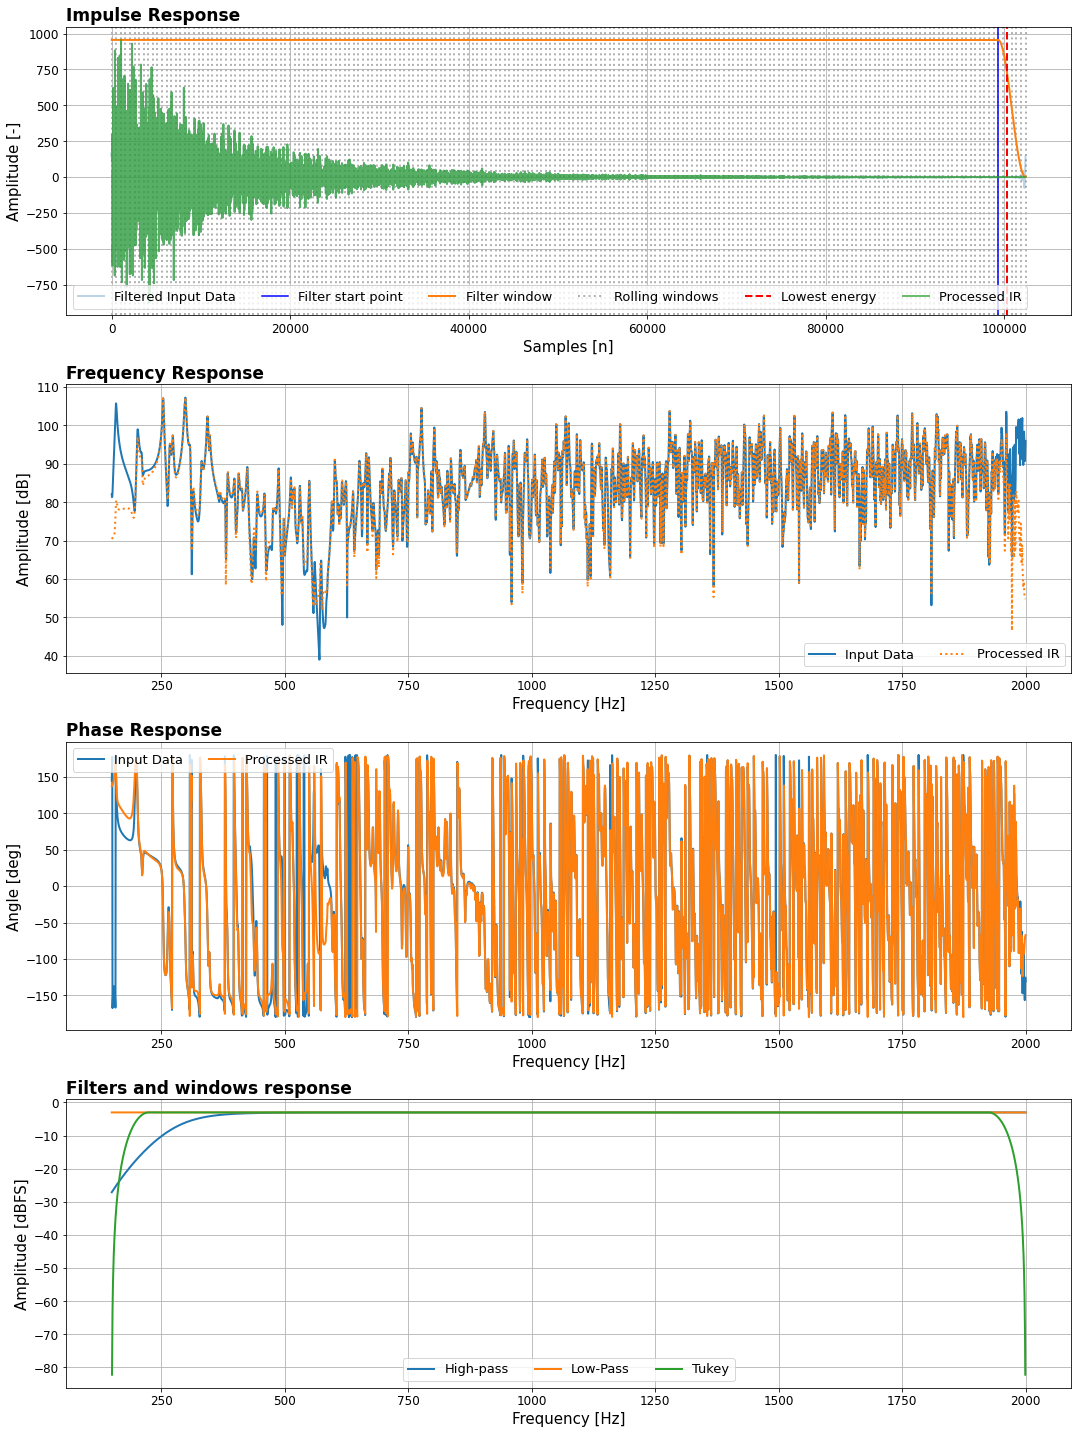

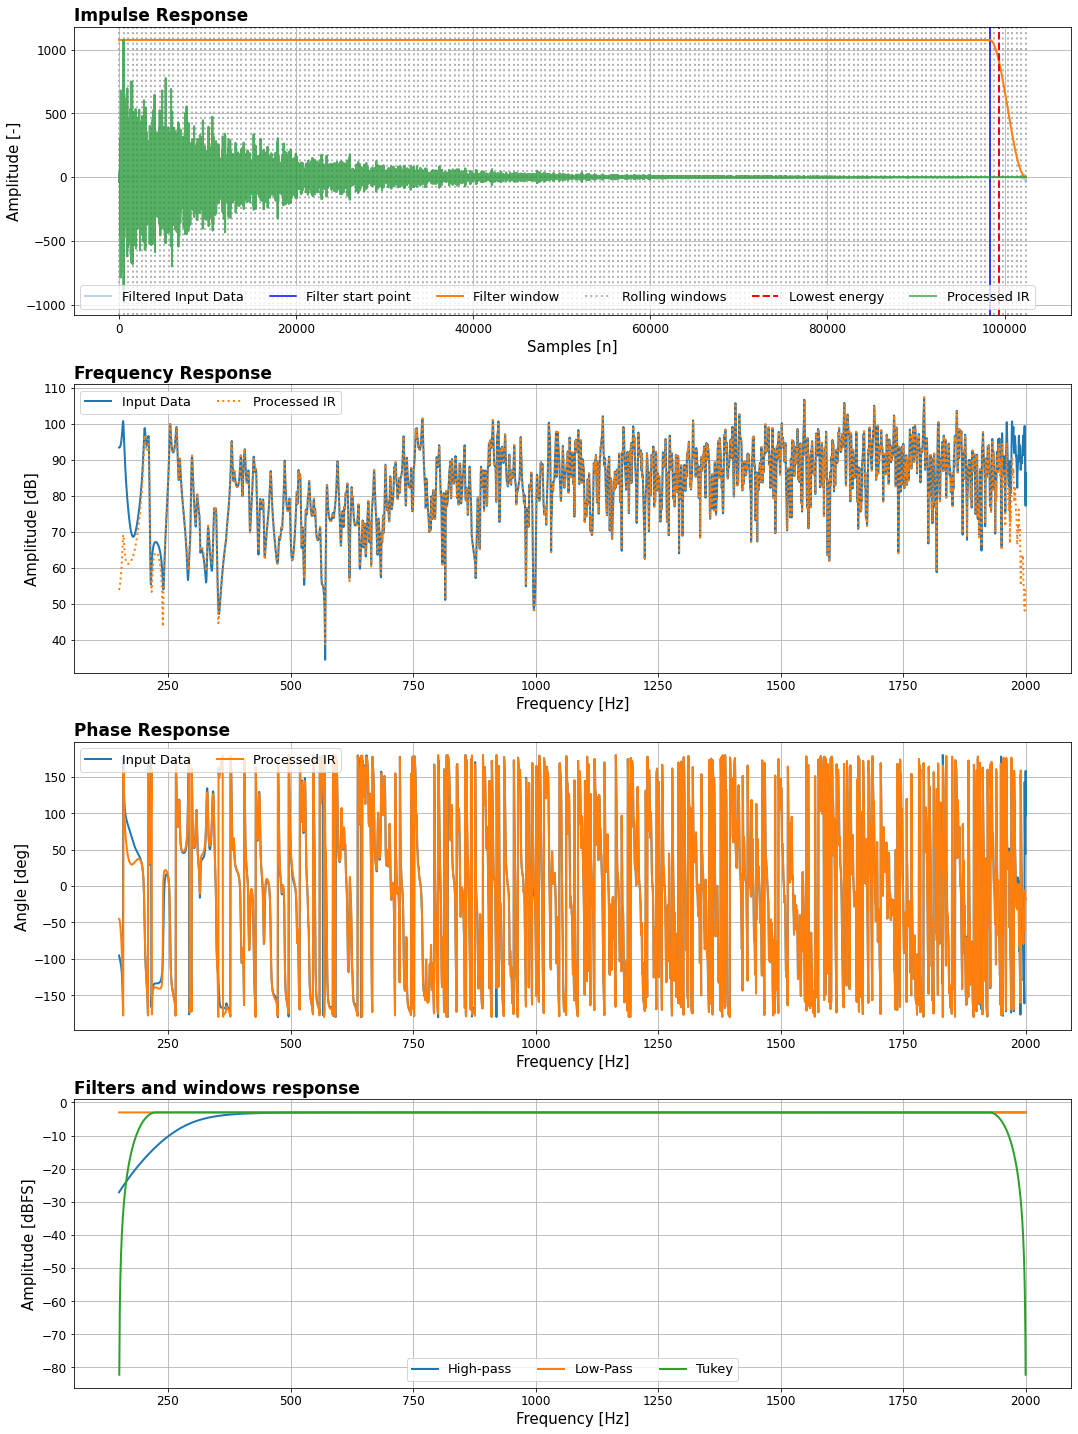

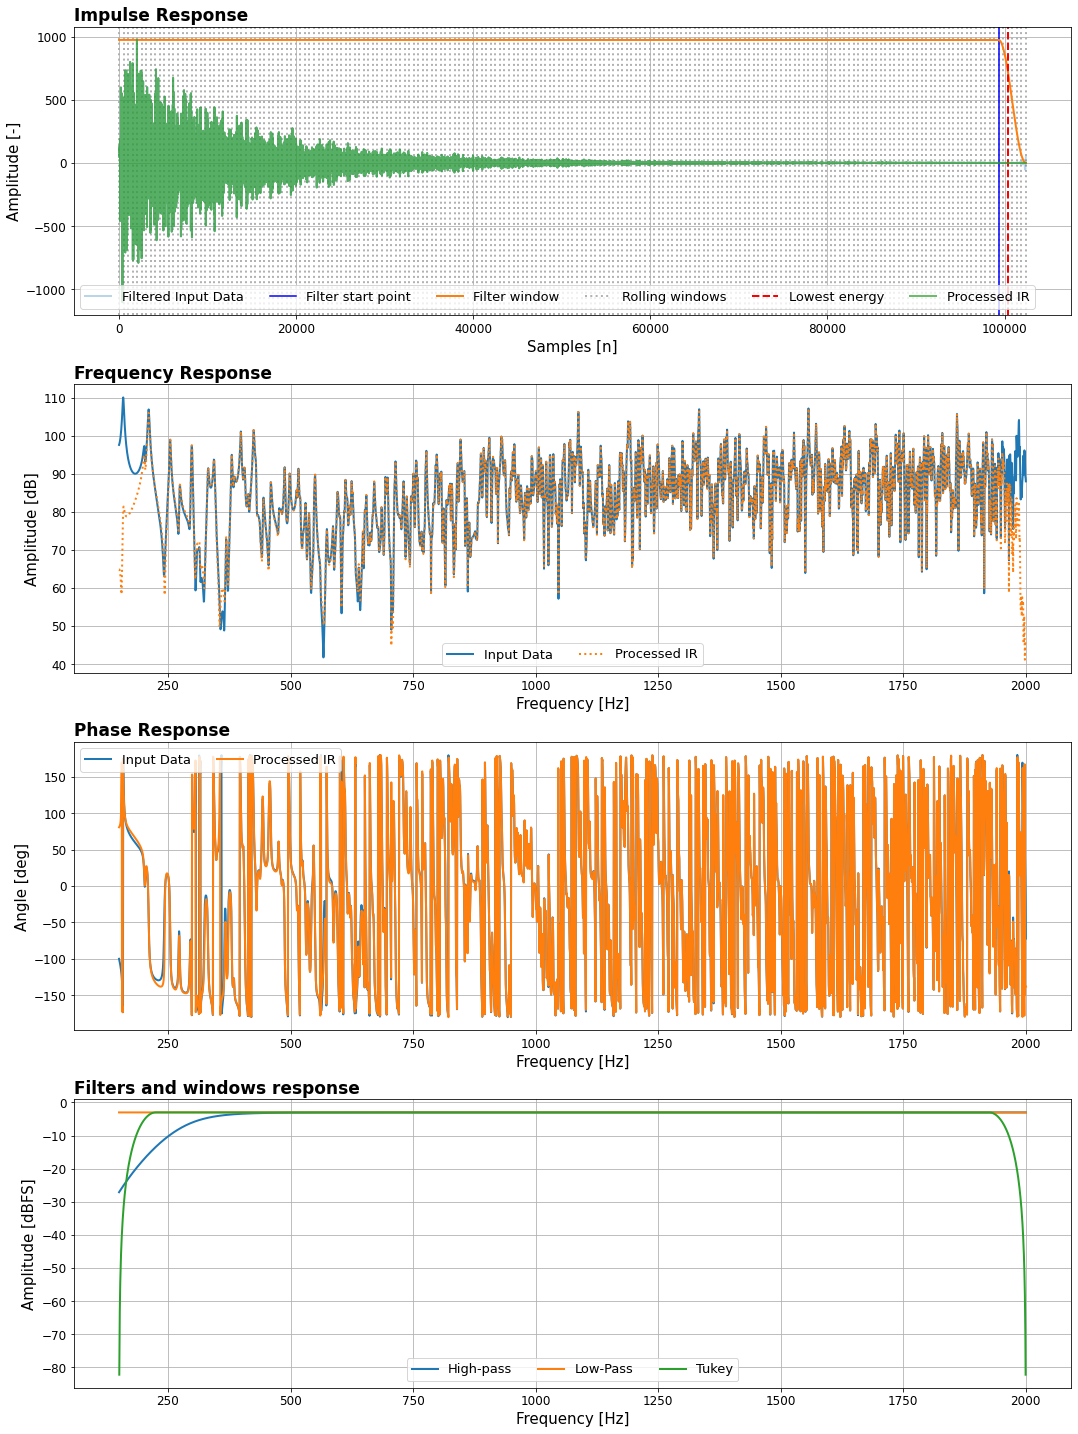

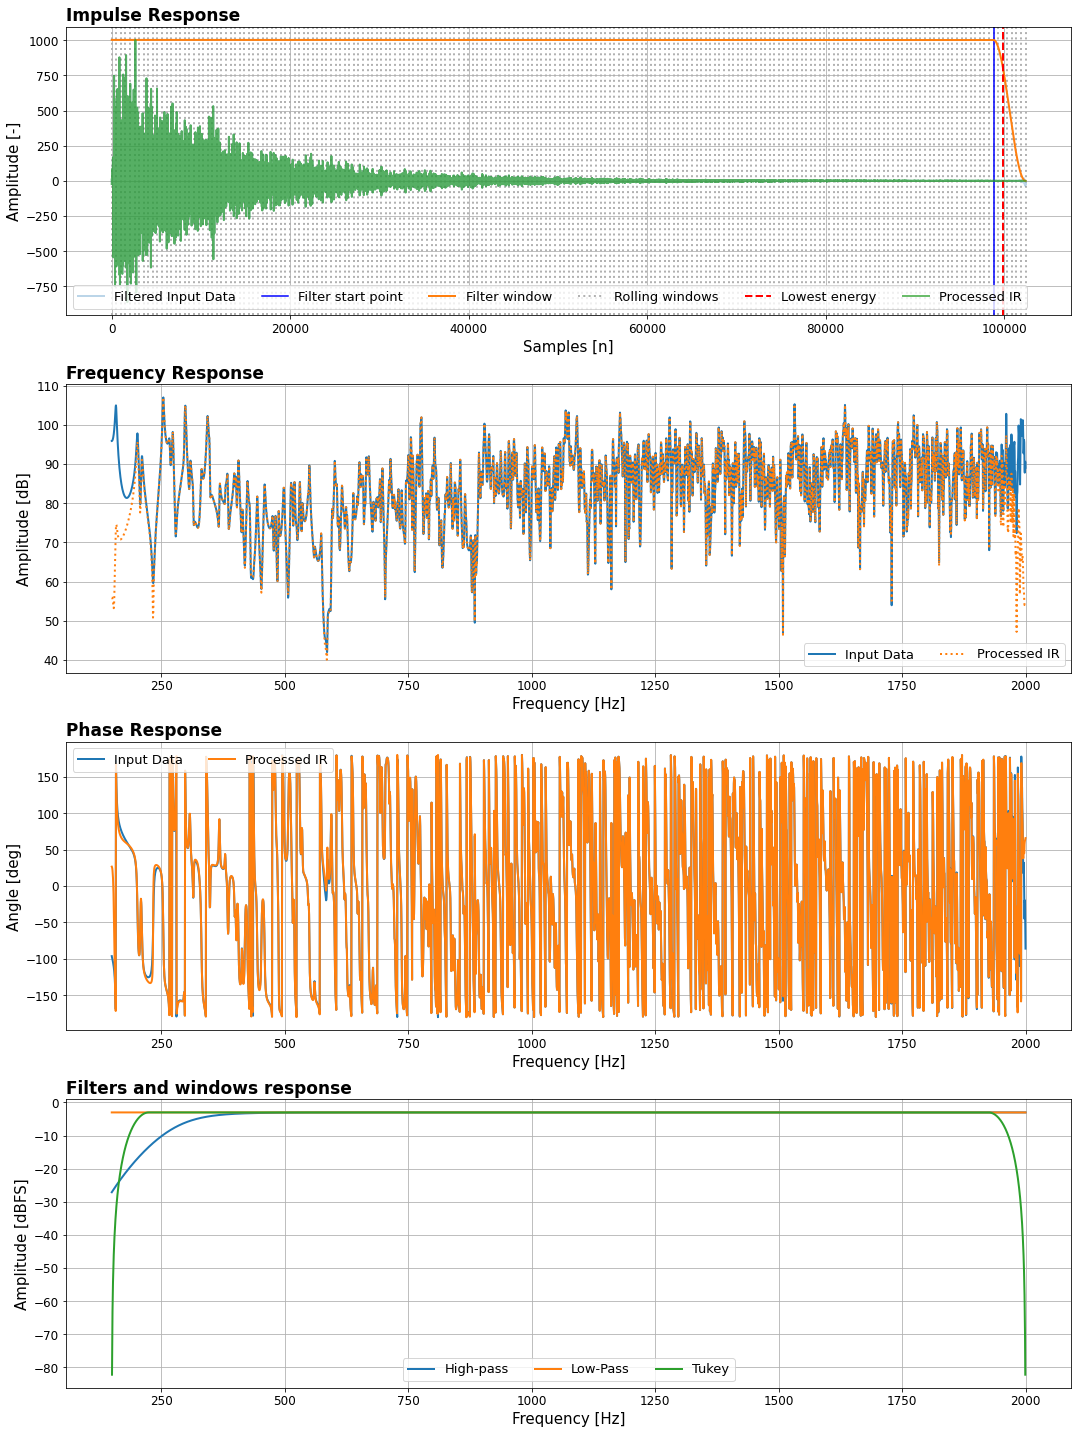

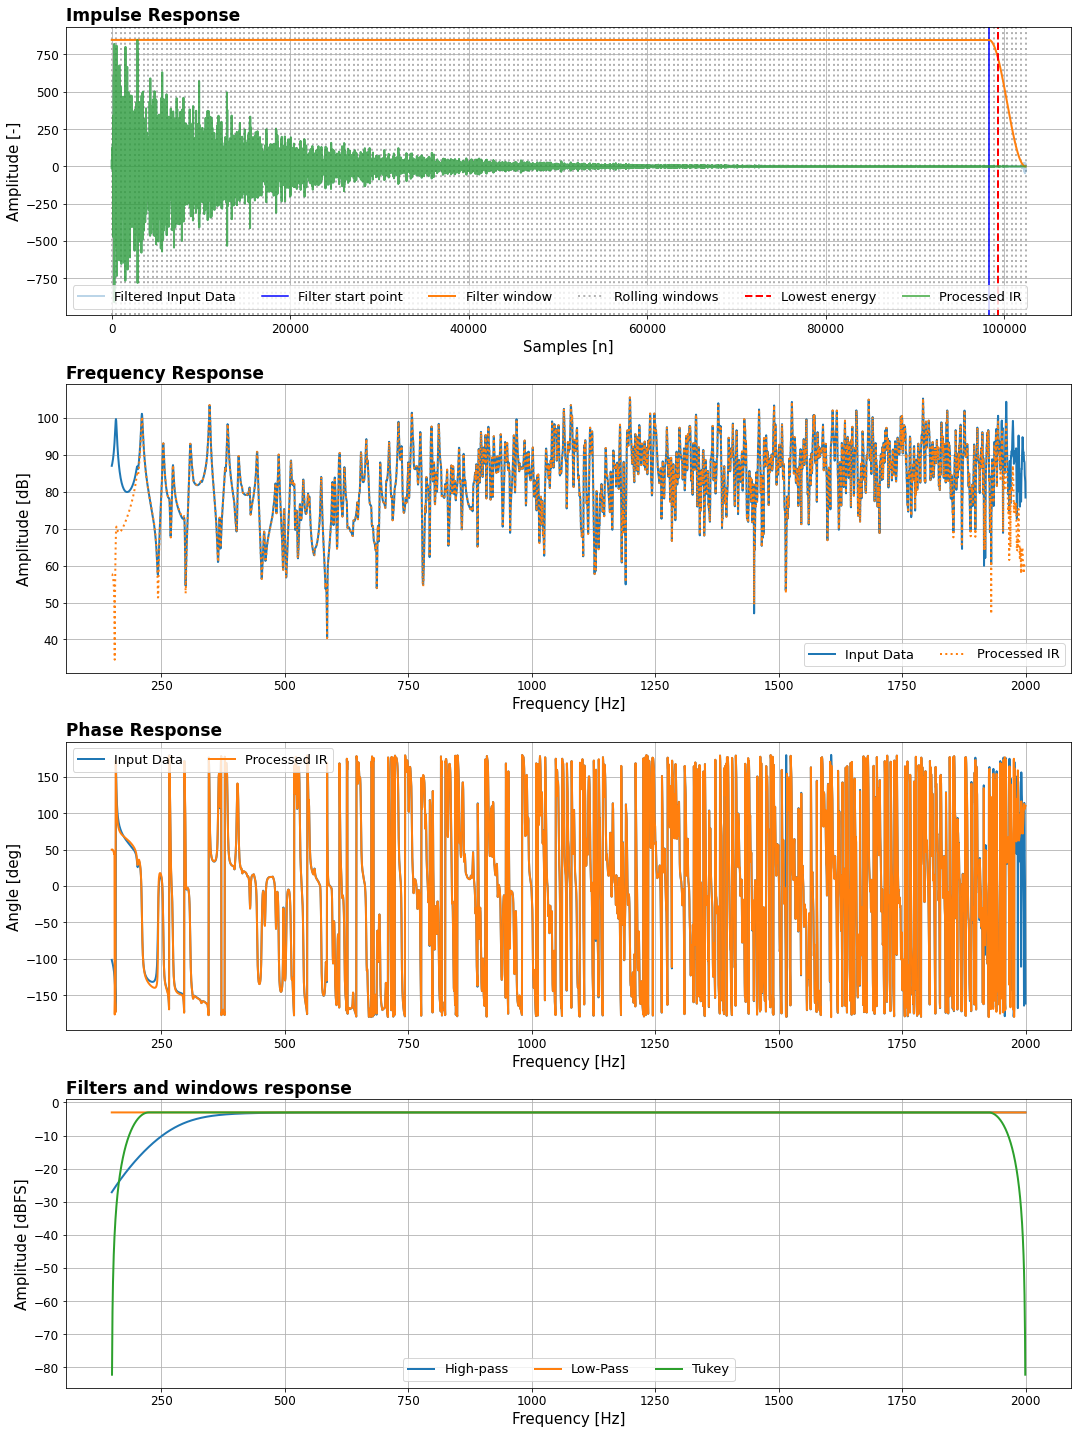

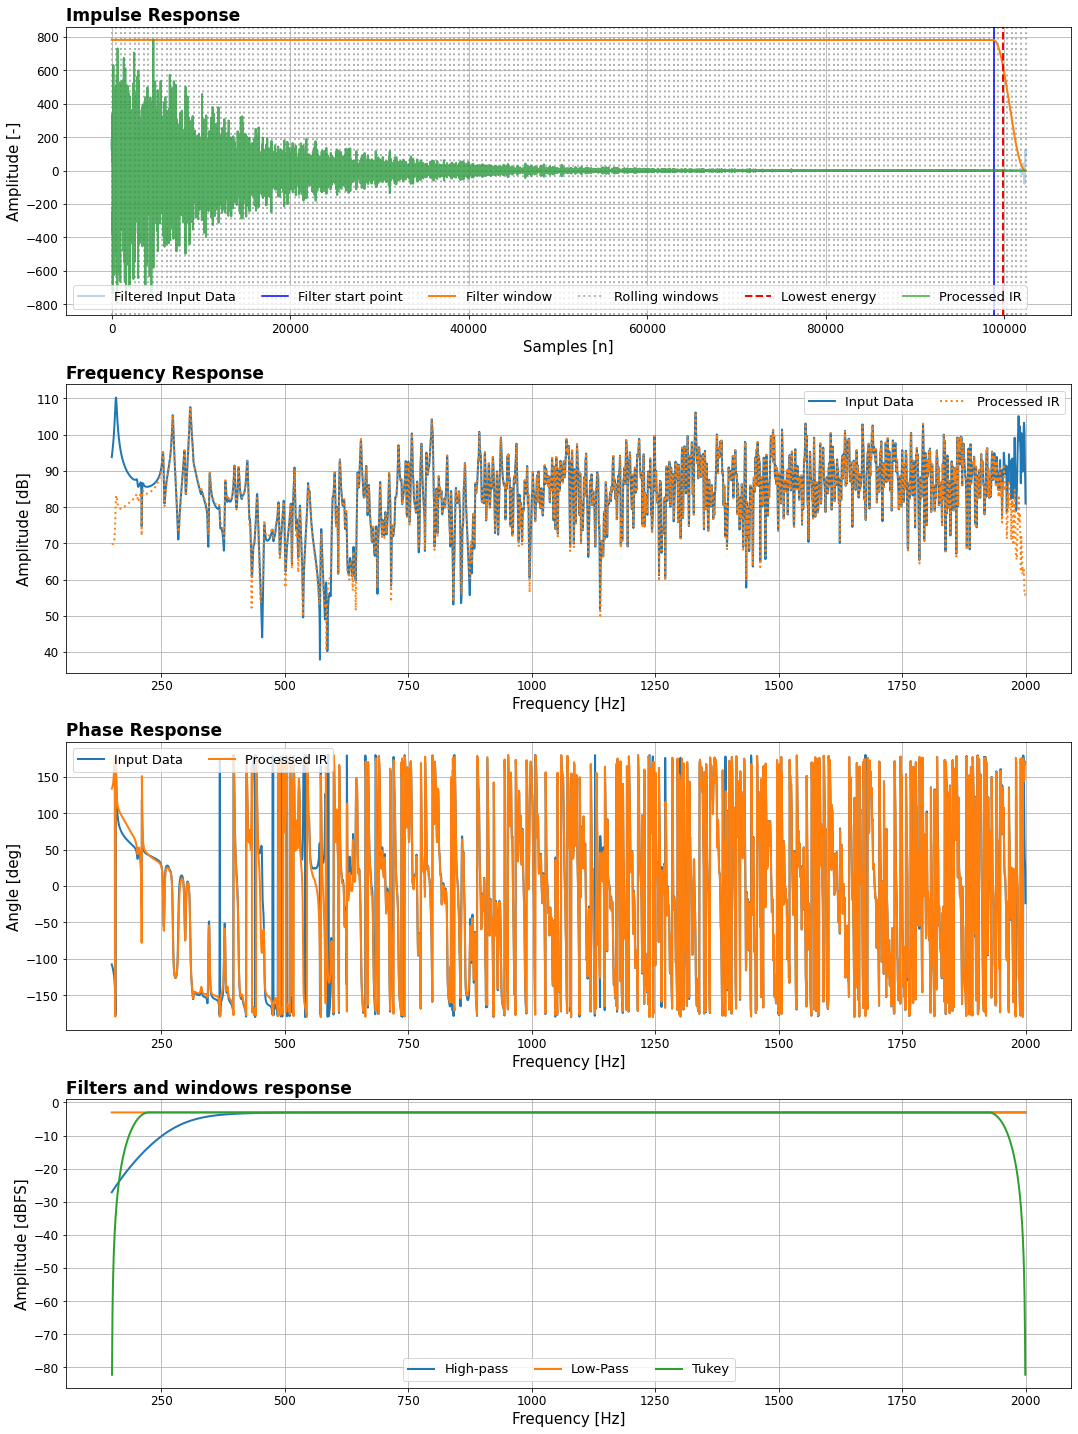

In [28]:
#%% Resposta Impulsiva
domain = fd.Domain(fmin, fmax,2,51200)
domain.alpha = 0.1
ir = np.zeros((len(RI_semMat['RIs_sz']),len(obj.pR[0,:])))
for n in range(0,len(obj.pR[0,:])):
    ir[:,n] = domain.compute_impulse_response(obj.pR[:,n], view=True, irr_filters=False)


In [29]:
# Salvar os dados p importar no MATLAB
from scipy.io import savemat
savemat('G:\Meu Drive\TCC\Simulacao_computacional\minicamara_semMat\RIs_simuladas.mat',{'RIs':ir,'freq':AC.freq})


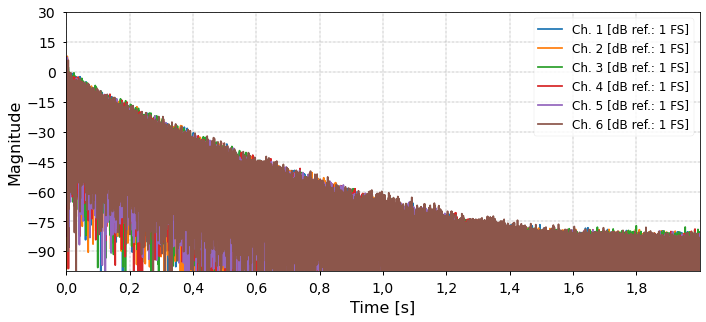

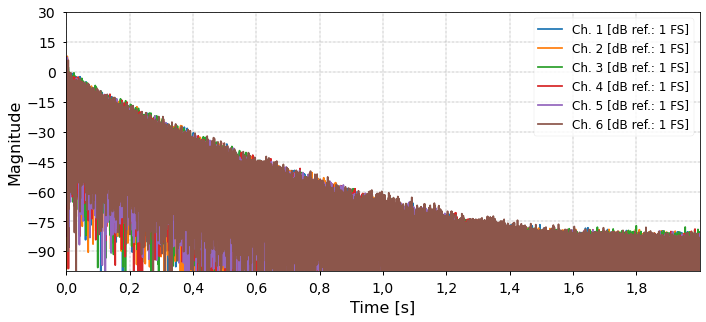

In [84]:

import pytta
txAmostragem = 51200 # [Hz]
# fftDegree = 19
# T = (2**fftDegree-1)/txAmostragem # [s]
# Cria vetor no tempo de um sinal aleatório
#meuRuido = np.random.randn(txAmostragem*T)
# SignalObj com sinal provido pelo usuário
RI_semMat = pytta.SignalObj(RI_semMat['RIs_sz'], 'time', txAmostragem) 
RI_semMat.plot_time_dB(yLim=[-100,30])

### Plote do campo de pressão

In [63]:
# Plote do campo de pressão
obj.pressure_field(frequencies = 300,renderer='browser',axis=['xy','yz'],saveFig=False,camera_angles=['diagonal_front'],extension='pdf')

G:\Meu Drive\TCC\Simulacao_computacional\codes\geo\mini-camarareverb.iges


100%|██████████| 203/203 [00:00<00:00, 2788.65it/s]



	Elapsed time to evaluate acoustic field: 0.09 minutes

